# Exploration of the dataset with human balance evaluations

Marcos Duarte

Here is an exploration on the data set of quantitative and qualitative evaluations of 231 subjects available at [https://zenodo.org/record/47671](https://zenodo.org/record/47671).  
See the companiom data set website [http://demotu.org/datasets/balance/](http://demotu.org/datasets/balance/) for more information.

First, let's import the necessary Python libraries and configure the environment:

In [1]:
import numpy as np
import pandas as pd
pd.set_option('precision', 4)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
sns.set_context("notebook", font_scale=1.4,
                rc={'font.size': 16, 'lines.linewidth': 1, 'lines.markersize': 8, 'axes.titlesize': 'x-large'})
import glob
import sys, os
sys.path.insert(1, r'./../functions')

# IPython widgets:
from IPython.display import display
import ipywidgets
from ipywidgets import FloatProgress, interactive

import qgrid  # pip install git+https://github.com/quantopian/qgrid
qgrid.nbinstall(overwrite=True)  # copies javascript dependencies to /nbextensions folder
qgrid.set_defaults(remote_js=True, precision=2)  # Set default options by calling "set_defaults" (optional)

from AMTIbsf import loadbsf
from psd import psd
from hyperellipsoid import hyperellipsoid

## Load information about all files of stabilography

In [2]:
fname = 'https://raw.githubusercontent.com/demotu/datasets/master/Balance/BDSinfo.txt'
BDSinfo = pd.read_csv(fname, sep='\t', header=0, index_col=None, engine='c', encoding='utf-8')
print("Information of %s subjects loaded (%s rows, %s columns)."
      %(len(pd.unique(BDSinfo.Subject)), BDSinfo.shape[0], BDSinfo.shape[1]))

Information of 231 subjects loaded (2741 rows, 62 columns).


Here are the first 20 rows and 10 columns of the data:

In [3]:
BDSinfo.iloc[:20, :10]
# or use the nice qgrid library:
#qgrid.show_grid(BDSinfo.iloc[:, :10])

,Subject,Trial,Vision,Surface,Age,AgeGroup,Gender,Height,Weight,BMI
0,1,BDS00001,Open,Firm,48.4167,Young,M,171.5,73.9,25.1256
1,1,BDS00002,Open,Firm,48.4167,Young,M,171.5,73.9,25.1256
2,1,BDS00003,Closed,Firm,48.4167,Young,M,171.5,73.9,25.1256
3,1,BDS00004,Closed,Firm,48.4167,Young,M,171.5,73.9,25.1256
4,1,BDS00005,Open,Foam,48.4167,Young,M,171.5,73.9,25.1256
5,1,BDS00006,Open,Foam,48.4167,Young,M,171.5,73.9,25.1256
6,1,BDS00007,Open,Foam,48.4167,Young,M,171.5,73.9,25.1256
7,1,BDS00008,Closed,Foam,48.4167,Young,M,171.5,73.9,25.1256
8,1,BDS00009,Closed,Foam,48.4167,Young,M,171.5,73.9,25.1256
9,1,BDS00010,Closed,Foam,48.4167,Young,M,171.5,73.9,25.1256


The BDSinfo file has 2741 rows for 231 subjects because there are 12 rows for each subject related to the 12 experimental trials (but there is a total of 31 trials missing). For now, to analyze the subjects's characteristics we can drop the additional rows for each subject:

In [4]:
info = BDSinfo.drop_duplicates(subset='Subject', inplace=False)
info.iloc[:10, :10]
#qgrid.show_grid(info.iloc[:, :10])

,Subject,Trial,Vision,Surface,Age,AgeGroup,Gender,Height,Weight,BMI
0,1,BDS00001,Open,Firm,48.4167,Young,M,171.5,73.90,25.1256
10,2,BDS00013,Open,Firm,33.0000,Young,F,157.5,54.20,21.8493
22,3,BDS00025,Open,Firm,27.5833,Young,F,154.0,44.00,18.5529
34,4,BDS00037,Open,Firm,49.7500,Young,M,178.1,80.70,25.4417
46,5,BDS00049,Closed,Firm,36.9167,Young,M,161.7,63.40,24.2476
58,6,BDS00061,Open,Firm,61.7500,Old,M,164.0,68.35,25.4127
70,7,BDS00073,Closed,Firm,18.3333,Young,F,162.0,56.45,21.5097
82,8,BDS00085,Open,Firm,19.1667,Young,M,176.8,75.60,24.1856
94,9,BDS00097,Closed,Foam,21.5833,Young,M,174.7,78.60,25.7535
106,10,BDS00109,Open,Foam,49.3333,Young,M,163.5,70.65,26.4288


## Age group and gender

Here are the number of subjetcs in the data set by age group and gender:

In [5]:
info = BDSinfo.drop_duplicates(subset='Subject', inplace=False)
print('Number of subjects per group (N=%d):' %len(info))
display(info[['Subject', 'AgeGroup', 'Gender']].groupby(['AgeGroup', 'Gender']).count())

Number of subjects per group (N=231):


Subject
AgeGroup Gender         
Old      F            75
         M            29
Young    F            63
         M            64

And the corresponding mean and standard deviation values:

In [6]:
pd.set_option('precision', 1)
print('Mean and SD age values across subjects per group and gender')
info.groupby(['AgeGroup', 'Gender'])['Age'].agg([np.mean, np.std])

Mean and SD age values across subjects per group and gender


mean   std
AgeGroup Gender            
Old      F       71.8   6.9
         M       69.8   6.2
Young    F       28.0   7.8
         M       30.8  10.1

## Disability and illness

Of the 231 subjects (127 young adults and 104 elderly adults), 23 of them were classified as a person with disability and 143 subjects declared to have at least one illness:

In [7]:
#info.loc[info.Disability!='No', 'Disability'] = 'Yes'
#info.loc[info.Illness!='No', 'Illness'] = 'Yes'
display(info[['Subject', 'AgeGroup', 'Disability', 'Illness']].groupby(['AgeGroup', 'Disability', 'Illness']).count())

Subject
AgeGroup Disability Illness         
Old      No         No            13
                    Yes           75
         Yes        No             2
                    Yes           14
Young    No         No            71
                    Yes           49
         Yes        No             2
                    Yes            5

Because there were more disabilities in the older group, 16 vs. 7, let's select only people without disability for the comparison from now on:

In [8]:
info = info.ix[info.Disability=='No']
print('Number of subjects without disability: %s' %len(info.Subject))

Number of subjects without disability: 208


## Age, weight, height, and BMI 

Let's visualize the age, weight, height, and BMI values by gender of the subjects:

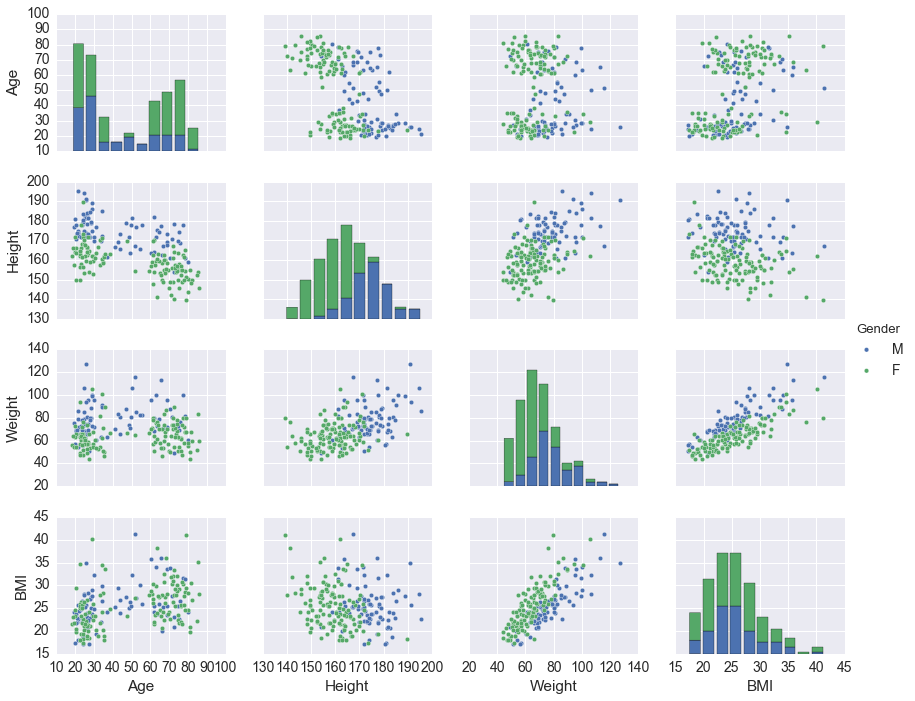

In [9]:
sns.pairplot(info[['Age', 'Gender', 'Height', 'Weight', 'BMI']], hue='Gender', size=2.5, aspect=1.2)
plt.show()

From figure above, we can see a biomodal distribution for the age characteristic; data are from young subjects, mostly between 20 and 30 yrs. old, and from elderly subjects, between 60 and 80 yrs. old. Men are slightly taller and heavier than women but they seem to have similar BMI.

## Fallers

Let's see how many subjects fell at least once in the last 12 months:

In [10]:
info[['AgeGroup', 'Falls12m']][info.Falls12m > 0].groupby(['AgeGroup']).count()

,Falls12m
AgeGroup,
Old,25
Young,28


So, surprisingly the number of young and elderly subjects who fell at least once in the last 12 months are similar (28% of tle elderly adults and 23% of the young adults fell).

 ## Qualitative evaluations
 
 Let's see the results for the Short Falls Efficacy Scale International test (FES-I), Mini Balance Evaluation Systems Test (Mini-BESTest), International Physical Activity Questionnaire Short Version (IPAQ); and Trail Making Test (TMT).
 
 The IPAQ data scores are coded as 'Low', 'Moderate' and 'High'; let's convert to numbers, '0', '1' and '2', for comparing with the other evaluations:

In [11]:
info.loc[info.IPAQ_S=='Low', 'IPAQ_S'] = 0
info.loc[info.IPAQ_S=='Moderate', 'IPAQ_S'] = 1
info.loc[info.IPAQ_S=='High', 'IPAQ_S'] = 2

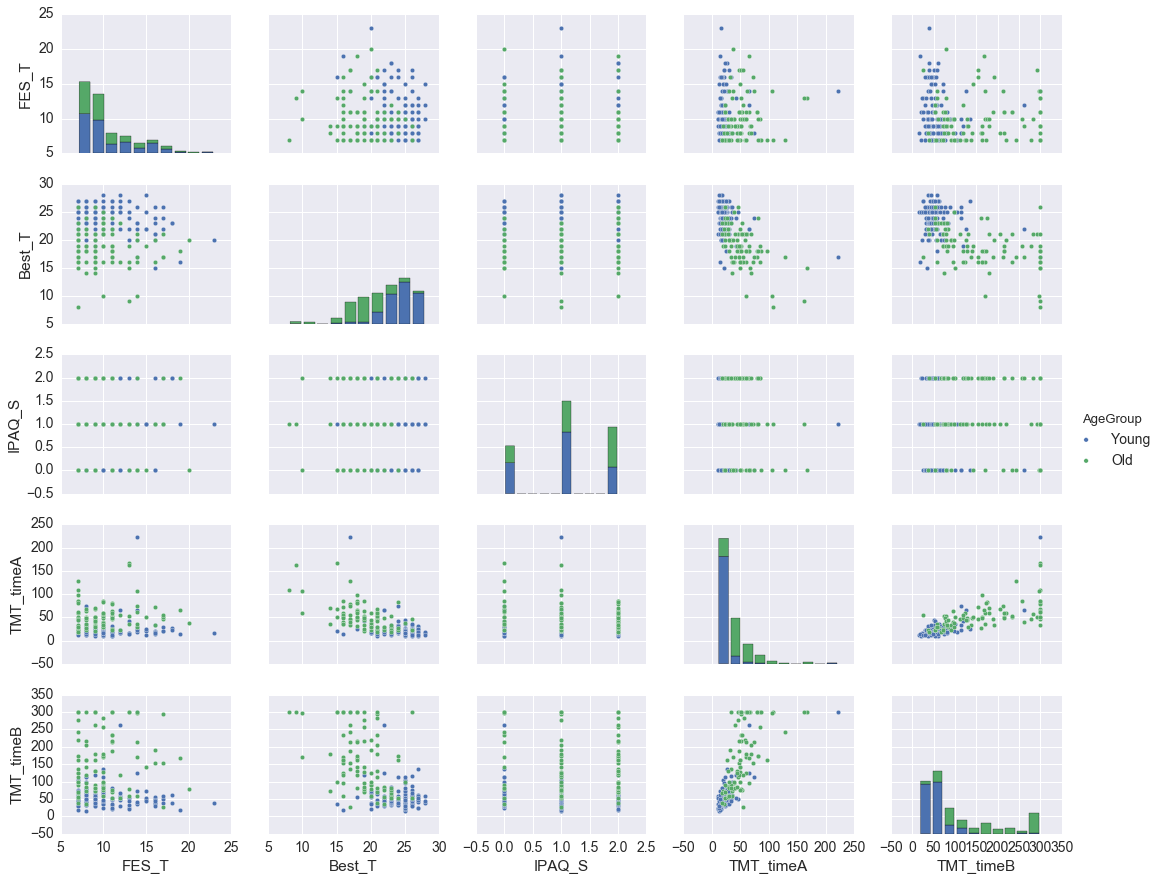

In [12]:
sns.pairplot(info[['AgeGroup', 'FES_T', 'Best_T', 'IPAQ_S', 'TMT_timeA', 'TMT_timeB']], hue='AgeGroup', aspect=1.2)
plt.show()

## Quantitative evaluation

The raw data from the stabilography evaluation, composed by the force platform signals plus the center of pressure (COP), in the anterior-posterior (ap), and medio-lateral (ml) directions, are stored in other files (2742 files!); the BSDinfo file just stores the names of these files according to subject's name and conditions.  
Here is an examplary plot of the eight signals (3 forces, 3 moments of force and 2 COPs) of the first trial of the first subject:

In [13]:
path2 = r'./../../../../Downloads/BDS/'  # path for the raw COP data
filename = os.path.join(path2, 'BDS00001.txt')
grf = pd.read_csv(filename, delimiter='\t', skiprows=1, header=None,
                  names=['Time','Fx','Fy','Fz','Mx','My','Mz','COPx','COPy'], engine='c')

In [14]:
def bdb_plot_grf(grf):
    """Auxliary plotting function to show GRF data.
    """
    
    Funits = 'N'
    Munits = 'Nm'
    COPunits = 'cm'
    t, Fx, Fy, Fz, Mx, My, Mz, COPx, COPy = [_ for _ in grf.values.T]
    COPx -= np.mean(COPx)
    COPy -= np.mean(COPy)
    
    plt.figure(figsize=(12, 3))

    gs = gridspec.GridSpec(1, 3)
    gs.update(wspace=0.4)
    ax7 = plt.subplot(gs[:-1])
    ax8 = plt.subplot(gs[2])

    ax7.set_xlabel('Time [s]')
    ax7.set_ylabel('COP [%s]' %COPunits)
    ax8.set_xlabel('COP ml [%s]' %COPunits)
    ax8.set_ylabel('COP ap [%s]' %COPunits)

    ax7.plot(t, COPx, 'b', label='COP ap')
    ax7.plot(t, COPy, 'r', label='COP ml')
    ax7.yaxis.set_label_coords(-.1, 0.5)
    ax7.legend(fontsize=12, loc='best', framealpha=.5)
    ax8.plot(COPy, COPx)
    ax8.locator_params(axis='both', nbins=5)

    plt.show()

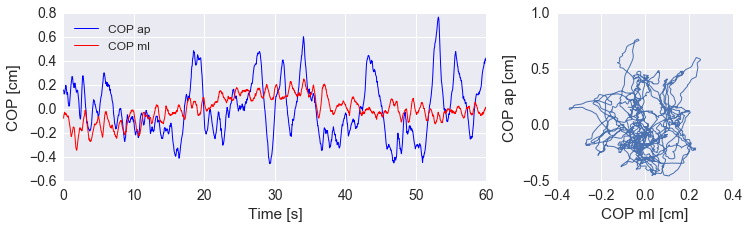

In [15]:
bdb_plot_grf(grf)

Let's load all files from the stabilography evaluation and calculate some variables to quantify the stabilography data. The notexbook http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/Stabilography.ipynb describes some of the most typical measurements employed to quantify postural sway using the COP data. Let's calculate here the variables COP area and COP mean velocity.

In [13]:
from scipy.signal import detrend

fp = FloatProgress(min=0, max=len(BDSinfo.Trial)-1)
display(fp)
path2 = r'./../../../../Downloads/BDS/'  # path for the raw COP data
freq = 100
for i, fname in enumerate(BDSinfo.Trial):
    filename = os.path.join(path2, fname + '.txt')
    fp.description = 'Reading data from file %s (%s/%s)' %(os.path.basename(filename), i+1, len(BDSinfo.Trial))
    fp.value = i
    grf = pd.read_csv(filename, delimiter='\t', skiprows=1, header=None,
                      names=['Time','Fx','Fy','Fz','Mx','My','Mz','COPx','COPy'], engine='c')   
    COP = grf[['COPx', 'COPy']].values
    # discard the first 5s for the accomodation period
    #grf = grf.iloc[5*freq:, :]
    #COP = COP[5*freq:, :]
    COP = detrend(COP, axis=0, type='linear')
    area, axes, angles, center, R = hyperellipsoid(COP, show=False)
    velo = np.sum(np.abs(np.sqrt(np.sum(np.diff(COP, axis=0)**2, axis=1))), axis=0)/(COP.shape[0]/freq)   
    BDSinfo.loc[i, 'COParea'] = area
    BDSinfo.loc[i, 'COPvelo'] = velo
    
BDSinfo.to_csv(os.path.join(path, 'BDSinfoCOP.txt'), sep='\t', encoding='utf-8')
BDSinfo.to_excel(os.path.join(path, 'BDSinfoCOP.xlsx'))

In [14]:
# read file with all metadata and COP variables from the GitHub repo:
fname = 'https://raw.githubusercontent.com/demotu/datasets/master/Balance/BDSinfoCOP.txt'
BDSinfo = pd.read_csv(fname, sep='\t', header=0, index_col=None, engine='c', encoding='utf-8')
print("Information from %s files successfully loaded (total of %s subjects)."
      %(len(BDSinfo), len(pd.unique(BDSinfo.Subject))))

Information from 2741 files successfully loaded (total of 231 subjects).


In [22]:
display(BDSinfo[['Subject', 'Trial', 'Vision', 'Surface', 'COParea', 'COPvelo']].head(15))
#qgrid.show_grid(BDSinfo[['Subject', 'Trial', 'Vision', 'Surface', 'COParea', 'COPvelo']])
print('%s subjects.' %len(pd.unique(BDSinfo.Subject)))

,Subject,Trial,Vision,Surface,COParea,COPvelo
0,1,BDS00001,Open,Firm,0.4,0.5
1,1,BDS00002,Open,Firm,0.5,0.5
2,1,BDS00003,Closed,Firm,0.6,0.6
3,1,BDS00004,Closed,Firm,1.2,0.6
4,1,BDS00005,Open,Foam,14.2,2.8
5,1,BDS00006,Open,Foam,18.2,2.7
6,1,BDS00007,Open,Foam,12.3,2.8
7,1,BDS00008,Closed,Foam,18.2,3.7
8,1,BDS00009,Closed,Foam,25.6,4.5
9,1,BDS00010,Closed,Foam,28.2,3.9


231 subjects.


Because we have 3 trials per condition for each subject, let's take the median across trials for each subject as representative of the subject:

In [24]:
BDSinfo = BDSinfo.groupby(['Subject','Vision','Surface','Illness','Disability','AgeGroup'], as_index=False).median()
display(BDSinfo[['Subject', 'Vision', 'Surface', 'COParea', 'COPvelo']].head(12))
#qgrid.show_grid(BDSinfo[['Subject', 'Vision', 'Surface', 'COParea', 'COPvelo']])
print('%s subjects.' %len(pd.unique(BDSinfo.Subject)))

,Subject,Vision,Surface,COParea,COPvelo
0,1,Closed,Firm,0.9,0.6
1,1,Closed,Foam,25.6,3.9
2,1,Open,Firm,0.5,0.5
3,1,Open,Foam,14.2,2.8
4,2,Closed,Firm,0.3,0.6
5,2,Closed,Foam,4.3,1.9
6,2,Open,Firm,0.5,0.7
7,2,Open,Foam,3.1,2.0
8,3,Closed,Firm,0.7,0.6
9,3,Closed,Foam,9.6,2.0


231 subjects.


Once again, we will not consider the subjects with disabilities because their numbers are unbalanced in the age groups:

In [25]:
BDSinfo = BDSinfo.ix[BDSinfo.Disability=='No']

Number of subjects without disabilities in the data set:

In [26]:
BDSinfo.drop_duplicates(subset='Subject')[['AgeGroup', 'Subject']].groupby(['AgeGroup']).count()

,Subject
AgeGroup,
Old,88
Young,120


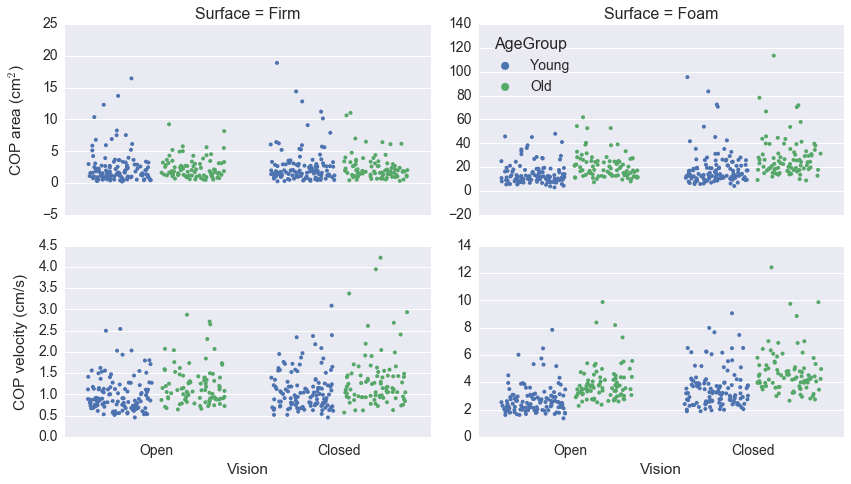

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(12, 7))

sns.stripplot(x='Vision', y='COParea', hue='AgeGroup', order=['Open', 'Closed'], data=BDSinfo[BDSinfo.Surface=='Firm'],
               jitter=.35, split=True, size=4, ax=ax[0,0])
ax[0,0].set_xlabel('')
ax[0,0].set_xticklabels('')
ax[0,0].set_ylabel('COP area (cm$^2$)')
ax[0,0].yaxis.set_label_coords(-.1, .5)
ax[0,0].legend('')
ax[0,0].set_title('Surface = Firm', fontsize=16)

sns.stripplot(x='Vision', y='COParea', hue='AgeGroup', order=['Open', 'Closed'], data=BDSinfo[BDSinfo.Surface=='Foam'],
               jitter=.35, split=True, size=4, ax=ax[0,1])
ax[0,1].set_xlabel('')
ax[0,1].set_xticklabels('')
ax[0,1].set_ylabel('')
ax[0,1].legend(title='AgeGroup', loc='upper left')
ax[0,1].set_title('Surface = Foam', fontsize=16)

sns.stripplot(x='Vision', y='COPvelo', hue='AgeGroup', order=['Open', 'Closed'], data=BDSinfo[BDSinfo.Surface=='Firm'],
               jitter=.35, split=True, size=4, ax=ax[1,0])
ax[1,0].set_ylabel('COP velocity (cm/s)')
ax[1,0].yaxis.set_label_coords(-.1, .5)
ax[1,0].legend('')

sns.stripplot(x='Vision', y='COPvelo', hue='AgeGroup', order=['Open', 'Closed'], data=BDSinfo[BDSinfo.Surface=='Foam'],
               jitter=.35, split=True, size=4, ax=ax[1,1])
ax[1,1].set_ylabel('')
ax[1,1].legend('')
plt.tight_layout()
plt.show()

**Figure. Plot of the variables COP area and COP velocity for each subject by age group at the different conditions (120 young adults and 88 older adults).**

The mean and standard deviation values for the variables COP area and COP velocity are:

In [28]:
pd.set_option('precision', 1)
BDSinfo.groupby(['AgeGroup', 'Vision', 'Surface'])['COParea', 'COPvelo'].agg([np.mean, np.std])

COParea       COPvelo     
                           mean   std    mean  std
AgeGroup Vision Surface                           
Old      Closed Firm        2.4   1.9     1.3  0.7
                Foam       28.2  16.8     4.7  1.6
         Open   Firm        2.4   1.6     1.2  0.5
                Foam       21.1  10.7     3.9  1.3
Young    Closed Firm        2.7   2.9     1.1  0.5
                Foam       18.8  14.6     3.6  1.4
         Open   Firm        2.5   2.6     1.0  0.4
                Foam       14.5   9.1     2.7  1.1

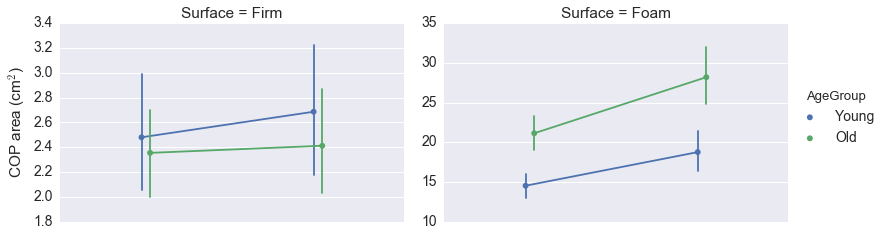

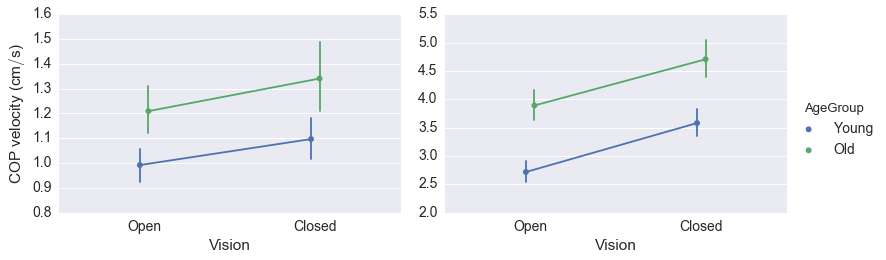

In [29]:
g0 = sns.factorplot(x='Vision', y='COParea', hue='AgeGroup', order=['Open', 'Closed'], data=BDSinfo,
                    estimator=np.mean, ci=95,
                    col='Surface', kind='point', dodge=True, sharey=False, size=4, aspect=1.4)
g0.set_xticklabels('')
g0.set_axis_labels('', 'COP area (cm$^2$)')
g1 = sns.factorplot(x='Vision', y='COPvelo', hue='AgeGroup', order=['Open', 'Closed'], data=BDSinfo,
                    estimator=np.mean, ci=95,
                    col='Surface', kind='point', dodge=True, sharey=False, size=4, aspect=1.4)
g1.set_axis_labels('Vision', 'COP velocity (cm$/$s)')
g1.set_titles('','')
plt.show()

**Figure. Plot of the mean and 95% CI for the variables COP area and COP velocity across subjects by age group at the different conditions (120 young adults and 88 older adults).**